<a href="https://colab.research.google.com/github/gianpDomiziani/TinyML/blob/main/data_drift_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Drift Detector on CIFAR-10 dataset
We'll see how the *Kolmogorov-Smirnov* test can be used to inference about the presence or not of *data-drift* in a incoming dataset against an original (initial) dataset. In particular, the used library allows to perform a features-wise two-samples K-S test. 

Since, we'll try to inference on a high-dimensional dataset, dimensional reduction is required. A method will be used: the **Untrained AutoEncoder UAC**.

We'll use the CIFAR-10 dataset, constiting of 32x32x3 images, equal splitted into 10 classes, as the original (initial) dataset. We'll use the CIFAR-10-C dataset as the incoming dataset. The incoming dataset will be perturbed, using a set of corruptions.

In [1]:
!pip install alibi_detect

     |████████████████████████████████| 153kB 7.6MB/s 
     |████████████████████████████████| 1.1MB 10.8MB/s 
     |████████████████████████████████| 1.8MB 26.8MB/s 
     |████████████████████████████████| 2.9MB 47.7MB/s 
     |████████████████████████████████| 890kB 44.7MB/s 
  Created wheel for mmh3: filename=mmh3-2.5.1-cp36-cp36m-linux_x86_64.whl size=37850 sha256=acd838f95b824270e51b506033bf81c38ecc88fed20a9c2a682c4284451afd3e
  Stored in directory: /root/.cache/pip/wheels/38/b4/ea/6e4e321c625d3320c0c496bf4088371546d8fce5f1dd71b219
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=a762f5cf91c42b5a96bf35e2b7bdc0f997732759bf7c4133a3364cde3be06fb4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built mmh3 sacremoses


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape

from alibi_detect.cd import KSDrift
from alibi_detect.cd.preprocess import UAE, HiddenOutput
from alibi_detect.models.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.utils.prediction import predict_batch
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

## Load Data
Original CIFAR-10 data

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

170500096/170498071 [==============================] - 4s 0us/step


## Corruptions
We can simulate all of these types of corruptions

In [8]:
corruptions = corruption_types_cifar10c()
corruptions

['brightness',
 'contrast',
 'defocus_blur',
 'elastic_transform',
 'fog',
 'frost',
 'gaussian_blur',
 'gaussian_noise',
 'glass_blur',
 'impulse_noise',
 'jpeg_compression',
 'motion_blur',
 'pixelate',
 'saturate',
 'shot_noise',
 'snow',
 'spatter',
 'speckle_noise',
 'zoom_blur']

In [9]:
corruption = ["gaussian_noise", "motion_blur", "brightness", "pixelate"]
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32')/255.0

We split the original test set into a reference dataset and a dataset which should not be rejected under the HP of the KS test. We split also the X_ref into corruptions types.

In [13]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test//2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
assert idx.all() != idx_h0.all()
X_ref, y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
assert X_ref.shape[0] == X_test.shape[0] // 2
assert X_ref.shape[1] == X_test.shape[1]
assert X_ref.shape == X_h0.shape
assert y_ref.shape == y_h0.shape


In [17]:
# check the classes are quite balanced.
classes, counts_ref = np.unique(y_ref, return_counts=True)
counts_h0 = np.unique(y_h0, return_counts=True)[1]
print("class Ref H0")
for cls, cref, ch0 in zip(classes, counts_ref, counts_h0):
  assert cref + ch0 == n_test // 10  # CIFAR-10 dataset is perfectly balanced
  print(f"{cls}     {cref} {ch0}")

class Ref H0
0     472 528
1     510 490
2     498 502
3     492 508
4     501 499
5     495 505
6     493 507
7     501 499
8     516 484
9     522 478


In [36]:
X_c = []
n_test = X_test.shape[0]
n_corr = len(corruption)
for i in range(n_corr):
  X_c.append(X_corr[i * n_test:(1 + i)*n_test])

We can visualize the same instance for each of the corruption type

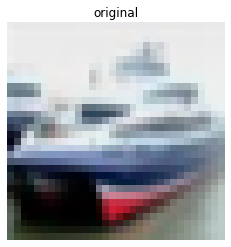

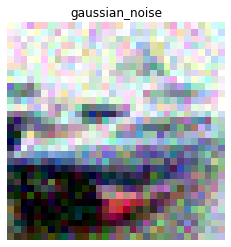

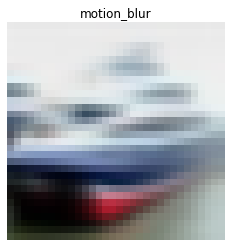

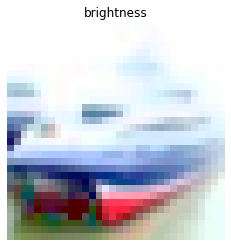

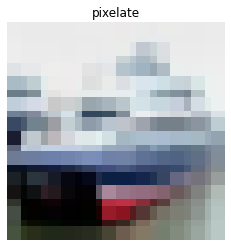

In [41]:
i = 1

n_test = X_test.shape[0]

plt.title("original")
plt.axis("off")
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
  plt.title(corruption[_])
  plt.axis("off")
  plt.imshow(X_corr[n_test * _ + i])
  plt.show()

We can check that the performance of a classification model on CIFAR10 decreases significantly on these corrupted instances.

In [38]:
dataset = "cifar10"
model = "resnet32"
clf = fetch_tf_model(dataset, model)
acc = clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]
print("Test set accuracy")
print("original acc: {:0.4f}".format(acc))
clf_accuracy = {'origina': acc}
for _ in range(len(corruption)):
  acc = clf.evaluate(scale_by_instance(X_c[_]), y_test, batch_size=128, verbose=0)[1]
  clf_accuracy[corruption[_]] = acc
  print("{}  acc: {:0.4f}".format(corruption[_], acc))

Test set accuracy
original acc: 0.9278
gaussian_noise  acc: 0.2208
motion_blur  acc: 0.6339
brightness  acc: 0.8913
pixelate  acc: 0.3666


The results make clear to us how much detect data drift is important.

## Detect drift
We're trying to detect drift on high-dimensionals data (32x32x3) using an aggregration of univariate KS-test. It therefore, makes sense to apply dimensionality reduction. Some dimensionality reduction algorithms, as described in the recent paper <a class="reference external" href="https://arxiv.org/pdf/1810.11953.pdf">Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift</a>, are available in the *alibi-detect* library.
In particular, **UAE** Untrained AutoEncoder, **BBSDs** (black-box shift detection using the classifier’s softmax outputs) and **PCA**.

## Untrained AutoEncoder

In [48]:
tf.random.set_seed(0)

#define encoder
encoding_dim = 34
encoder = tf.keras.models.Sequential([
                                      InputLayer(input_shape=(32, 32, 3)),
                                      Conv2D(64, 4, strides=2, padding="same", activation=tf.nn.relu),
                                      Conv2D(128, 4, strides=2, padding="same", activation=tf.nn.relu),
                                      Conv2D(512, 4, strides=2, padding="same", activation=tf.nn.relu),
                                      Flatten(),
                                      Dense(encoding_dim,)

])

uae = UAE(encoder_net=encoder)
preprocess_kwargs = {"model": uae, "batch_size": 128}

#initialize drift detector
p_val = .05
cd = KSDrift(
    p_val=p_val,        # p-value for K-S test
    X_ref=X_ref,       # test against original test set
    preprocess_X_ref=True,  # already preprocess X_ref at init stage to save time
    preprocess_kwargs=preprocess_kwargs,
    alternative='two-sided'  # other options: 'less', 'greater'
)

# it is also possible to save/load a detector
# save_detector(file_path)
# cd = load_detector(file_path)

Let's check if the detector predicts drifts within the original dataset

In [49]:
preds_h0 = cd.predict(X_h0)
labels = ["No!", "Yes!"]
print(f"Drift?  {labels[preds_h0['data']['is_drift']]}")

Drift?  No!


As expected no drift has occured. We can also inspect the p-value for each of the predictions. 

In [53]:
preds_h0['data']

{'distance': array([0.0236, 0.0364, 0.015 , 0.0144, 0.0202, 0.0162, 0.0196, 0.016 ,
        0.0108, 0.0162, 0.0198, 0.0122, 0.0212, 0.0224, 0.0158, 0.0144,
        0.0194, 0.0208, 0.0138, 0.021 , 0.011 , 0.0194, 0.015 , 0.0198,
        0.0194, 0.0126, 0.0174, 0.0212, 0.0146, 0.013 , 0.0172, 0.022 ,
        0.0148, 0.0144], dtype=float32),
 'is_drift': 0,
 'p_val': array([0.12345381, 0.00265409, 0.62716705, 0.677735  , 0.25943416,
        0.52796143, 0.2920585 , 0.5441424 , 0.93250304, 0.52796143,
        0.28087384, 0.850771  , 0.21113992, 0.16264398, 0.5604951 ,
        0.677735  , 0.30355498, 0.22956407, 0.72781175, 0.22020556,
        0.9228168 , 0.30355498, 0.62716705, 0.28087384, 0.30355498,
        0.82224816, 0.43545538, 0.21113992, 0.66088647, 0.79201305,
        0.45025542, 0.17771819, 0.6440195 , 0.677735  ], dtype=float32),
 'threshold': 0.0014705882352941176}

Let's now see the predictions for the perturbed dataset.

In [57]:
for X, c in zip(X_c, corruption):
  preds = cd.predict(X)
  print("Prediction:")
  print(f"Drift? {labels[preds['data']['is_drift']]}")
  print("Feature-wise p_value:")
  print(preds['data']['p_val'])

Prediction:
Drift? Yes!
Feature-wise p_value:
[1.3167676e-01 8.9514272e-09 3.1007592e-02 4.0792778e-01 2.1807582e-05
 1.7468357e-05 2.9143179e-03 9.5987767e-03 5.8114827e-03 2.5698198e-03
 8.6622059e-02 8.4146664e-02 8.9963677e-04 4.8503268e-01 2.1316923e-02
 1.1266356e-03 5.8933697e-08 2.2633269e-03 9.4535154e-01 3.8903630e-03
 1.4266117e-01 6.7980494e-03 8.1470889e-01 2.7950103e-03 6.0683548e-01
 2.9143179e-03 4.0521021e-03 1.2925932e-02 9.4129611e-04 1.7832204e-04
 5.1960558e-02 1.1177201e-01 1.1322660e-04 1.8266843e-03]
Prediction:
Drift? Yes!
Feature-wise p_value:
[1.7493351e-03 9.5925157e-11 1.8527109e-02 1.6260068e-01 3.8931589e-04
 6.2688382e-06 1.9522957e-05 1.6100140e-07 7.4963848e-04 3.0614465e-04
 7.6357084e-03 8.9963677e-04 1.4693730e-03 1.3873853e-04 1.2925932e-02
 4.3942747e-03 1.6894298e-06 7.0398796e-06 7.9720902e-01 1.7506430e-11
 5.0361138e-02 3.1728068e-01 7.2645240e-02 2.7166676e-05 2.3648527e-02
 1.4062161e-03 1.5892429e-06 1.5345249e-04 1.2428301e-06 8.5970649e-0

Very well, our detector classifies correctly all the cases. Note how all the p-values are below the **0.05** threshold.